#Kaggle Kickstarter Projectでのロジスティック回帰

・KaggleURL
https://www.kaggle.com/kemical/kickstarter-projects

#全体の流れ
全体の流れは以下の通りとする
1. データセットを調べる
2. データの読み込み
3. 前処理を行う
4. 特徴量を選択する
5. モデルを学習する
6. モデルを評価する
7. まとめ

# 1.データセットを調べる
---
## データセット ks-projects-201801.csv
  * ID：内部ID
  * name：プロジェクト名
  * cetegory：カテゴリー
  * main_category：メインカテゴリー
  * currency：使用する通貨
  * deadline：締切日
  * goal：ゴール金額
  * launched：開始日
  * pledged：契約金額
  * state：プロジェクトの状態
  * backers：後援者数
  * country：国
  * usd pledged：契約金額（ドル換算）
  * usd_pledged_real：実質契約金額（ドル換算）
  * usd_goal_real：ゴール金額（ドル換算）



In [ ]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# 2.データの読み込み

In [ ]:
df_ks = pd.read_csv("ks-projects-201801.csv")

# 要約統計量
df_ks.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [ ]:
# データの要約
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


#3.前処理を行う

データは378661行あり、name、usd pledgedに欠損行が存在するため、欠損行を削除する

In [ ]:
# 欠損値行削除
df_ks = df_ks.dropna()
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                374860 non-null  int64  
 1   name              374860 non-null  object 
 2   category          374860 non-null  object 
 3   main_category     374860 non-null  object 
 4   currency          374860 non-null  object 
 5   deadline          374860 non-null  object 
 6   goal              374860 non-null  float64
 7   launched          374860 non-null  object 
 8   pledged           374860 non-null  float64
 9   state             374860 non-null  object 
 10  backers           374860 non-null  int64  
 11  country           374860 non-null  object 
 12  usd pledged       374860 non-null  float64
 13  usd_pledged_real  374860 non-null  float64
 14  usd_goal_real     374860 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 45.8+ MB


In [ ]:
# stateの状態を調べる
print(df_ks['state'].value_counts())

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64


In [ ]:
# stateがsuccessful,failのものに絞り込む
df_ks = df_ks[df_ks['state'].str.contains("success") | df_ks['state'].str.contains("failed")]

# steteがsuccessfulの場合1、failの場合0とする
df_ks['state_flg'] = df_ks['state'].apply(lambda x : 1 if x == "successful" else 0)

print(df_ks['state_flg'].value_counts())

0    197611
1    133851
Name: state_flg, dtype: int64


#4.特徴量を選択する
回帰に不要な列を削除する

In [ ]:
# 関連しない項目
# 後にならないと分からない項目

drop_idx = ['ID', 'name', 'currency', 'deadline', 'launched', 'country', 'pledged', 'state', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
df_ks = df_ks.drop(drop_idx, axis=1)

df_ks.head()

,category,main_category,goal,state_flg
0,Poetry,Publishing,1000.0,0
1,Narrative Film,Film & Video,30000.0,0
2,Narrative Film,Film & Video,45000.0,0
3,Music,Music,5000.0,0
5,Restaurants,Food,50000.0,1


In [ ]:
#pd.plotting.scatter_matrix(df_ks, figsize=(10, 10))
#plt.show()

In [ ]:
# 質的変数をダミー変数化
df_ks = pd.get_dummies(df_ks)

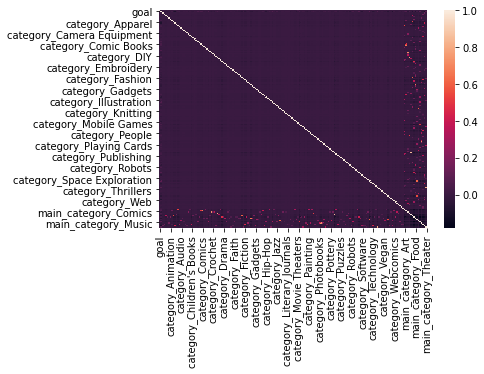

In [ ]:
# 相関関係をヒートマップで確認
sns.heatmap(df_ks.corr())
plt.show()

#5.モデルを学習する

##ロジスティック回帰で分類

In [ ]:
y = df_ks['state_flg'].values
X = df_ks.drop('state_flg', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

#6.モデルを評価する

In [ ]:
y_est = clf.predict(X)

print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

print('正答率 = {:.3f}'.format(100* accuracy_score(y, y_est)))

対数尤度 = -13.947
正答率 = 59.618


In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,197610,1
実績 successful,133850,1


In [ ]:
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 59.618%
適合率（Precision） = 50.000%
再現率（Recall） = 0.001%
F1値（F1-score） = 0.001%


# 7.まとめ

ロジスティック回帰による予測が1つを除いてすべてfailedの予測となり、正答率59.618%と予測ができていない結果となっている。

特徴量から学習ができていない。
